In [10]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumenations

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 405.1 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 717.3 kB/s eta 0:00:0000:0100:08
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 2.8 MB/s eta 0:00:0000:0100:01
ERROR: Could not find a version that satisfies the requirement albumenations (from versions: none)
ERROR: No matching distribution found for albumenations


Importing Necessary Modules

In [2]:
import os
import time 
import uuid
import cv2

In [1]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 40

In [3]:
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print('Collection image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0] global ./modules/videoio/src/cap_gstreamer.cpp (1100) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


Collection image 0
Collection image 1
Collection image 2
Collection image 3
Collection image 4
Collection image 5
Collection image 6
Collection image 7
Collection image 8
Collection image 9
Collection image 10
Collection image 11
Collection image 12
Collection image 13
Collection image 14
Collection image 15
Collection image 16
Collection image 17
Collection image 18
Collection image 19
Collection image 20
Collection image 21
Collection image 22
Collection image 23
Collection image 24
Collection image 25
Collection image 26
Collection image 27
Collection image 28
Collection image 29
Collection image 30
Collection image 31
Collection image 32
Collection image 33
Collection image 34
Collection image 35
Collection image 36
Collection image 37
Collection image 38
Collection image 39


In [16]:
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

Limit GPU Memory Growth

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.expermiental.set_memory_growth(gpu, True)

In [18]:
tf.config.list_physical_devices('GPU')

[]

Loading Image Into TF Date Pipeline

In [19]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle = False)

Checking If The Data/Images Are Loaded

In [20]:
images.as_numpy_iterator().next()




b'data/images/d69c29e3-578f-11ed-9b10-088fc30da5ad.jpg'

In [21]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(byte_img)
    print(img.shape)
    return img

In [22]:
images = images.map(load_image)

(None, None, None)


In [23]:
images.as_numpy_iterator().next()

array([[[135, 145, 120],
        [141, 147, 119],
        [149, 150, 116],
        ...,
        [148, 216, 237],
        [149, 217, 240],
        [151, 219, 242]],

       [[132, 141, 120],
        [136, 144, 120],
        [147, 148, 117],
        ...,
        [149, 217, 238],
        [150, 218, 241],
        [151, 219, 242]],

       [[125, 135, 124],
        [130, 138, 123],
        [140, 142, 121],
        ...,
        [150, 218, 241],
        [149, 216, 242],
        [150, 217, 243]],

       ...,

       [[ 93,  80,  46],
        [ 94,  81,  46],
        [ 95,  82,  47],
        ...,
        [ 78, 108, 110],
        [ 87, 112, 116],
        [ 91, 115, 117]],

       [[ 91,  80,  50],
        [ 90,  79,  47],
        [ 90,  79,  47],
        ...,
        [ 83, 112, 110],
        [ 86, 115, 113],
        [ 89, 115, 114]],

       [[ 88,  79,  50],
        [ 88,  79,  48],
        [ 88,  77,  47],
        ...,
        [ 85, 114, 112],
        [ 85, 114, 110],
        [ 84, 113, 109]]

In [24]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Viewing Raw Images With Matplotlib

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)


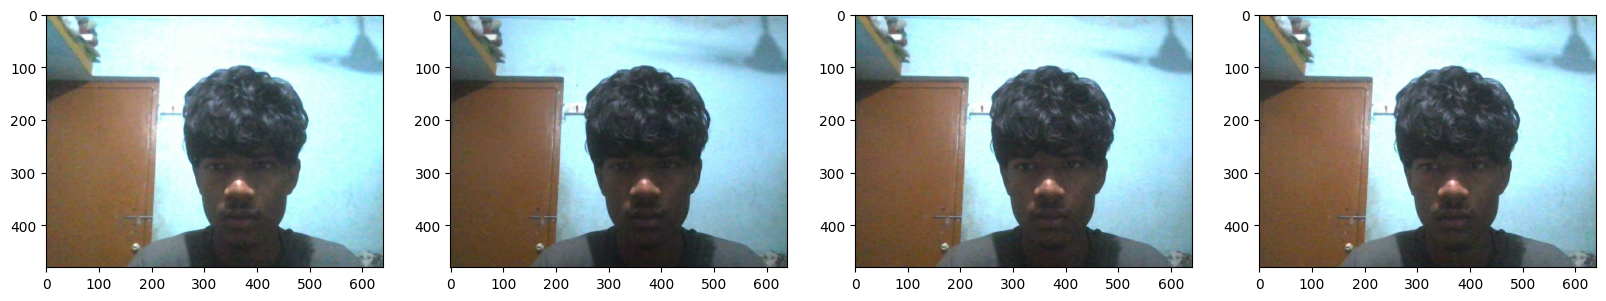

In [25]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    print(image.shape)
    ax[idx].imshow(image)

plt.show()

Partition Unaugmented Data

Move The Mathcing Labels

In [26]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)


Applying Image Augmentation On Images And Label Using Albumentations

In [27]:
import albumentations as alb

In [28]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5), alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2), alb.RGBShift(p=0.2), alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations', 
                                                    label_fields=['class_labels']))

Load A Test Image And Annotation With OpenCV And JSON

In [29]:
img = cv2.imread(os.path.join('data', 'train', 'images', 'd6efc0fc-578f-11ed-be4b-088fc30da5ad.jpg'))
# plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()

In [30]:
with open(os.path.join('data', 'train' ,'labels', 'd6efc0fc-578f-11ed-be4b-088fc30da5ad.json'), 'r') as f:
    label = json.load(f)

In [31]:
label['shapes']

[{'label': 'face',
  'points': [[196.15384615384613, 78.97435897435898],
   [529.4871794871794, 453.33333333333337]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

Extract Co-ordinates And Rescale To Match Image Resolution

In [32]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords


[196.15384615384613, 78.97435897435898, 529.4871794871794, 453.33333333333337]

In [33]:
coords = list(np.divide(coords, [640, 480, 640, 480]))
coords

[0.3064903846153846,
 0.16452991452991453,
 0.8273237179487178,
 0.9444444444444445]

Apply Augmentations And View Results

In [34]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
augmented

{'image': array([[[ 49,  63,  91],
         [ 46,  63,  90],
         [ 43,  61,  90],
         ...,
         [ 95,  91,  80],
         [ 95,  91,  80],
         [ 95,  91,  80]],
 
        [[ 50,  64,  93],
         [ 49,  64,  96],
         [ 47,  64,  97],
         ...,
         [ 98,  94,  83],
         [ 98,  94,  83],
         [ 99,  95,  84]],
 
        [[ 50,  63,  95],
         [ 51,  66,  99],
         [ 51,  67, 103],
         ...,
         [ 99,  95,  84],
         [100,  96,  85],
         [101,  97,  86]],
 
        ...,
 
        [[252, 231, 170],
         [253, 232, 170],
         [254, 233, 172],
         ...,
         [218, 195, 139],
         [215, 191, 137],
         [209, 188, 133]],
 
        [[252, 230, 172],
         [252, 230, 172],
         [253, 231, 173],
         ...,
         [212, 192, 135],
         [211, 190, 135],
         [208, 187, 132]],
 
        [[253, 230, 174],
         [253, 230, 174],
         [253, 229, 175],
         ...,
         [208, 189,

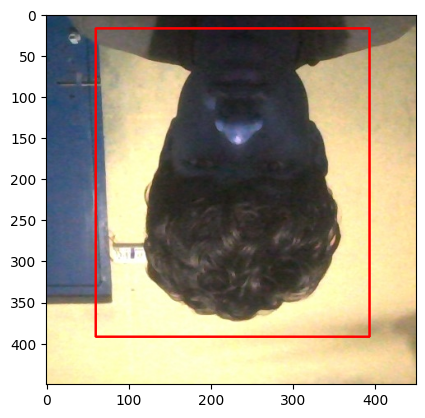

In [35]:
cv2.rectangle(augmented['image'],
                tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                (255, 0, 0), 2)
plt.imshow(augmented['image'])

Run Augmentation Pipeline

In [36]:


for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                path = os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json')
                print(path)
                with open(path , "x") as f:
                    print(os.path.exists(path))
                    json.dump(annotation, f)
                    

        except Exception as e:
            print(e)



aug_data/train/labels/efbe01bb-578f-11ed-9b30-088fc30da5ad.0.json
[Errno 17] File exists: 'aug_data/train/labels/efbe01bb-578f-11ed-9b30-088fc30da5ad.0.json'
aug_data/train/labels/f531437f-578f-11ed-abe2-088fc30da5ad.0.json
[Errno 17] File exists: 'aug_data/train/labels/f531437f-578f-11ed-abe2-088fc30da5ad.0.json'
aug_data/train/labels/db47e3ad-578f-11ed-898e-088fc30da5ad.0.json
[Errno 17] File exists: 'aug_data/train/labels/db47e3ad-578f-11ed-898e-088fc30da5ad.0.json'
aug_data/train/labels/ef1a7314-578f-11ed-a24c-088fc30da5ad.0.json
[Errno 17] File exists: 'aug_data/train/labels/ef1a7314-578f-11ed-a24c-088fc30da5ad.0.json'
aug_data/train/labels/d7de6432-578f-11ed-b5be-088fc30da5ad.0.json
[Errno 17] File exists: 'aug_data/train/labels/d7de6432-578f-11ed-b5be-088fc30da5ad.0.json'
aug_data/train/labels/f34807f0-578f-11ed-a02f-088fc30da5ad.0.json
[Errno 17] File exists: 'aug_data/train/labels/f34807f0-578f-11ed-a02f-088fc30da5ad.0.json'
aug_data/train/labels/f5d31321-578f-11ed-98fd-088fc3

Loading Augmented Images To Tensorflow Dataset

In [37]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

(None, None, None)


In [38]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

(None, None, None)


In [39]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

(None, None, None)


Prepare Labels

Build Label Loading Functions

In [40]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    
    return [label['class']], label['bbox']

Load Labels To TF Dataset

In [41]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))  

In [42]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))  

In [43]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))  

Combining Label And Image Samples

Check Partition Lengths

In [44]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4200, 4200, 1200, 1200, 600, 600)

Create Final Datasets(Images/Labels)

In [45]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(8)

In [46]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(8)

In [47]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(8)

Viewing Images And Annotations

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


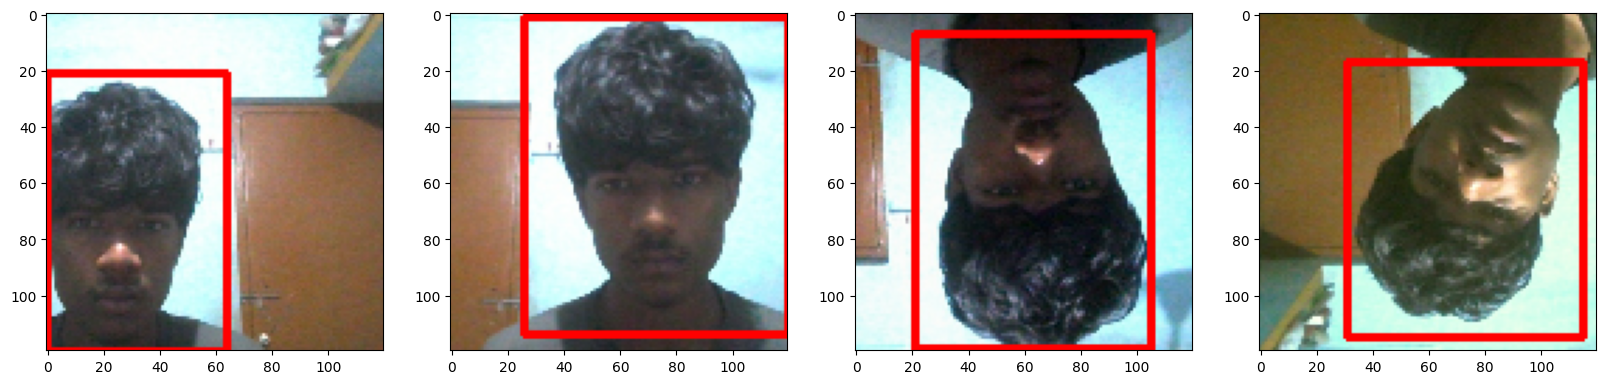

In [56]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

Building Deep Learning Using Functional API

Import Layers And Base Network

In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

Downloading VGG16

In [61]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 36s 1us/step


In [62]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Building Instance Of Network

In [63]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    #Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    #Bounding Box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(1, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])

    return facetracker
